<a href="https://colab.research.google.com/github/eghrthrjdtsed/-------------------------/blob/master/Home_work_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [772]:
import numpy as np
from PIL import Image
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [773]:
# Извлеките данные из zip-файлов
with zipfile.ZipFile('train.zip', 'r') as data_r:
    data_r.extractall()

In [774]:
with zipfile.ZipFile('test.zip', 'r') as data_r:
    data_r.extractall()

In [775]:
# Функция загрузки данных
def download_data(path):
    data = []
    for path_image in sorted(os.listdir(path=path)):
        image = Image.open(path + path_image)  # Открыть изображение
        data.append(np.array(image))  # Загрузить пиксели
    return data

In [776]:
# Загрузка данных обучения и тестирования
X_train = download_data("train/images/")
Y_train = download_data("train/masks/")
X_test = download_data("test/images/")
Y_test = download_data("test/masks/")

array([[[177, 181, 184],
        [205, 209, 212],
        [219, 222, 227],
        ...,
        [226, 229, 244],
        [230, 233, 250],
        [243, 246, 255]],

       [[217, 221, 224],
        [244, 248, 251],
        [252, 255, 255],
        ...,
        [229, 232, 247],
        [217, 220, 235],
        [208, 211, 226]],

       [[234, 238, 241],
        [252, 255, 255],
        [250, 253, 255],
        ...,
        [240, 242, 255],
        [237, 239, 252],
        [226, 228, 241]],

       ...,

       [[201, 198, 209],
        [221, 218, 229],
        [221, 215, 225],
        ...,
        [241, 234, 224],
        [255, 250, 240],
        [255, 251, 241]],

       [[194, 191, 202],
        [215, 212, 223],
        [223, 217, 227],
        ...,
        [222, 215, 205],
        [230, 223, 213],
        [223, 216, 206]],

       [[212, 209, 220],
        [195, 192, 203],
        [179, 173, 183],
        ...,
        [240, 233, 223],
        [255, 248, 238],
        [253, 246, 236]]], dtype=uint8)
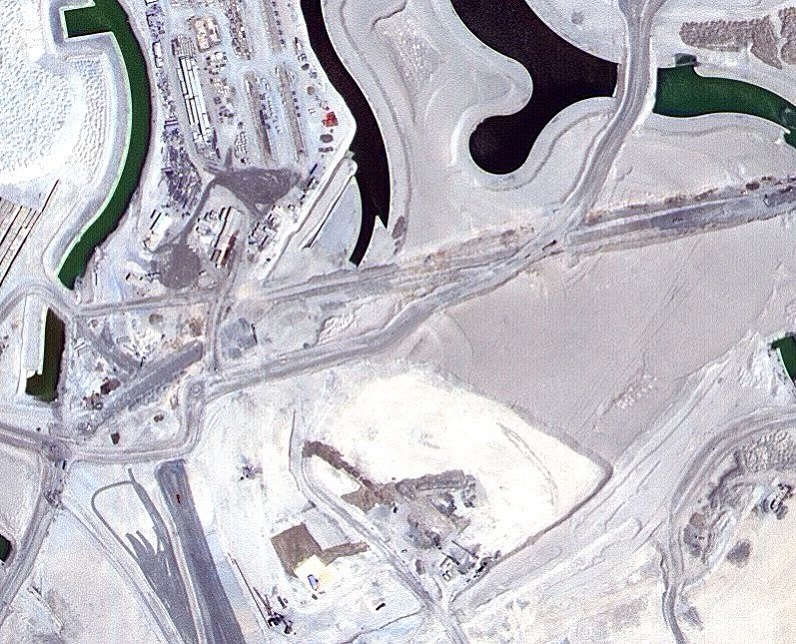

In [777]:
X_train[0]

In [778]:
#Функция изменения размера изображения
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [779]:
X_train, Y_train = resize(X_train, Y_train)

In [780]:
X_test, Y_test = resize(X_test, Y_test)

In [781]:
# Определить цветовую палитру
palette = {
    0: (60, 16, 152),  # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155)  # Unlabeled
}

In [782]:
invert_palette = {v: k for k, v in palette.items()}

In [783]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [784]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [785]:
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [786]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [787]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [788]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [789]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [790]:
# Определить архитектуру U-Net
def unet():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # модель unet с Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [791]:
unet_model = unet()

In [792]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [793]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 24s 24s/step - loss: 2.5563 - accuracy: 0.0719 - val_loss: 1.2656 - val_accuracy: 0.5975
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 1.3348 - accuracy: 0.5397 - val_loss: 1.1235 - val_accuracy: 0.6050
Epoch 3/10
1/1 [==============================] - 19s 19s/step - loss: 1.0789 - accuracy: 0.6270 - val_loss: 1.0781 - val_accuracy: 0.6051
Epoch 4/10
1/1 [==============================] - 17s 17s/step - loss: 1.0918 - accuracy: 0.6272 - val_loss: 1.0397 - val_accuracy: 0.6051
Epoch 5/10
1/1 [==============================] - 16s 16s/step - loss: 1.0607 - accuracy: 0.6272 - val_loss: 1.0137 - val_accuracy: 0.6051
Epoch 6/10
1/1 [==============================] - 16s 16s/step - loss: 1.0298 - accuracy: 0.6272 - val_loss: 1.0112 - val_accuracy: 0.6051
Epoch 7/10
1/1 [==============================] - 16s 16s/step - loss: 1.0244 - accuracy: 0.6272 - val_loss: 1.0169 - val_accuracy: 0.6051
Epoch 8/10
1/1 [===========

## Вывод: </br>
Этот код выполняет сегментацию изображения с использованием модели __U-Net__. Данные извлекаются из zip-файлов и предварительно обрабатываются путем изменения размера изображений и масок до размера 128x128 пикселей. </br> Модель __U-Net__ определяется с использованием функционального __API Keras__ и обучается на предварительно обработанных данных за 10 эпох. </br>
Модель компилируется с использованием оптимизатора _Адама_ и __категориальной кросс-энтропийной потери__. Ход обучения отслеживается с помощью метрики точности. </br>
Скрипт использует библиотеки __TensorFlow__ и __Keras__ для глубокого обучения и обработки изображений. </br>
Модель __U-Net__ — это популярная архитектура для задач сегментации изображений, и сценарий использует модифицированную версию архитектуры, которая принимает изображения RGB в качестве входных данных и выводит маску с шестью классами. Скрипт также включает в себя увеличение данных посредством случайных преобразований входных изображений во время обучения.